In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
#load data - store it in train dataframe
train = pd.DataFrame()
for i in range(13):
    file_name = 'events_England_' + str(i+1) + '.json'
    path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', file_name)
    with open(path) as f:
        data = json.load(f)
    train = pd.concat([train, pd.DataFrame(data)])


In [5]:
train

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
43145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
43146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
43147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
43148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234


In [6]:
shots = train.loc[train['subEventName'] == 'Shot']
#get shot coordinates as separate columns
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
#calculate distance and angle
shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
#if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)

In [8]:
shots.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,X,Y,C,Distance,Angle,Goal
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,12.60,27.88,6.12,14.007655,0.467241,1
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,15.75,35.36,1.36,15.808608,0.453557,0
91,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280,4.20,35.36,1.36,4.414703,1.375115,1
128,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,19.95,22.44,11.56,23.057235,0.274666,0
249,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,26.25,20.40,13.60,29.563872,0.219665,0


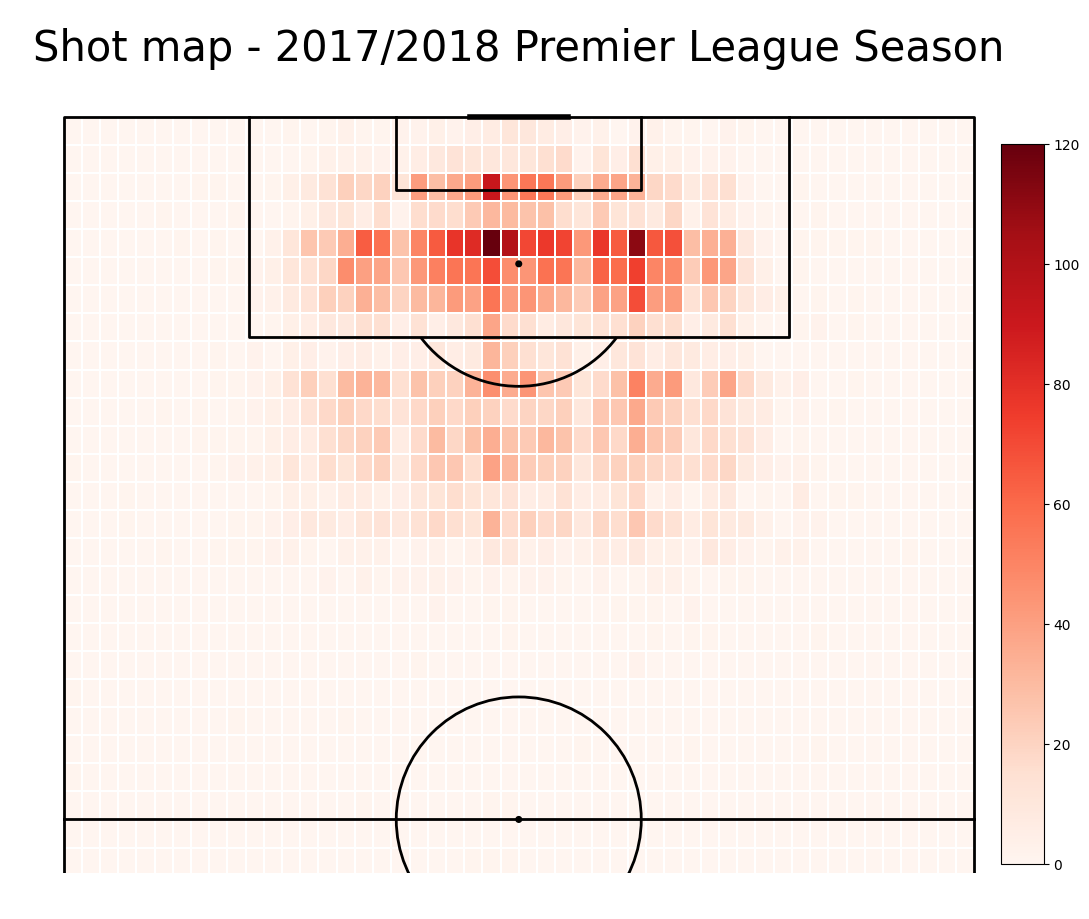

In [9]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#subtracting x from 105 but not y from 68 because of inverted Wyscout axis
#calculate number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)
#make heatmap
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

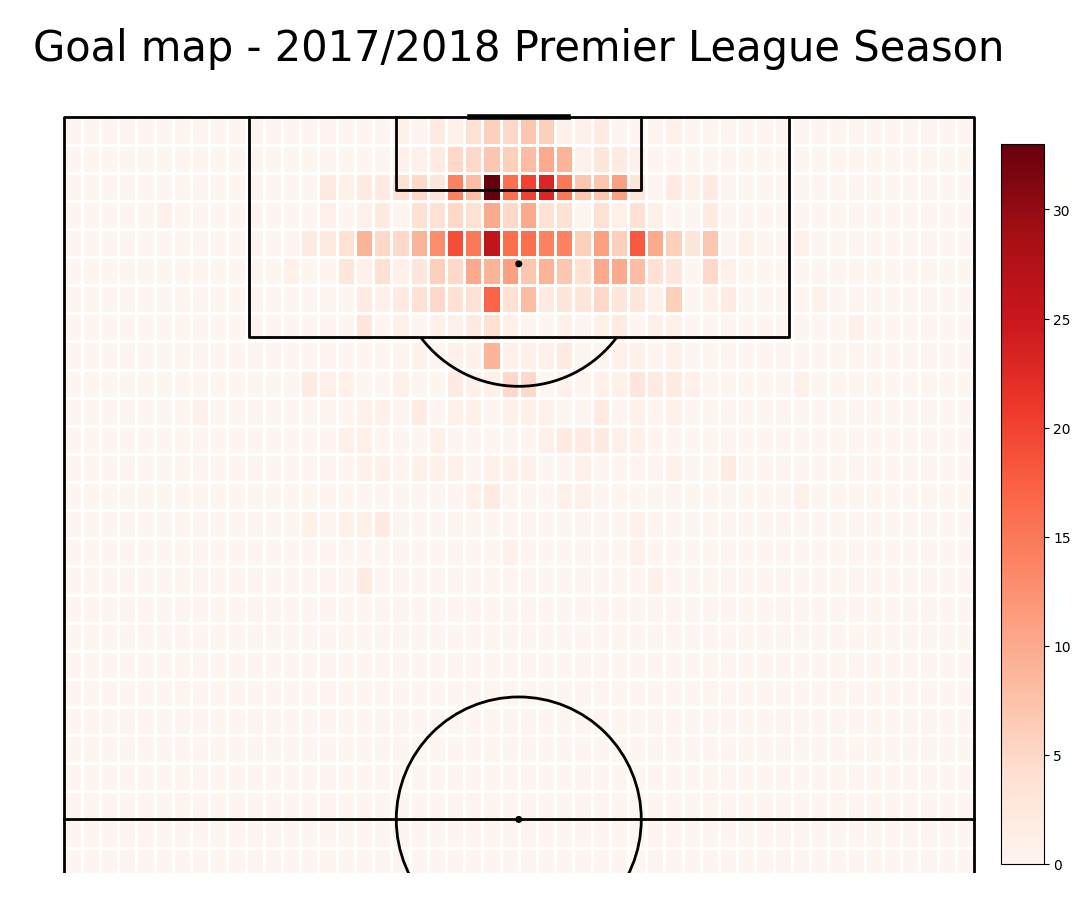

In [10]:
#take only goals
goals = shots.loc[shots["Goal"] == 1]
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#calculate number of goals in each bin
bin_statistic_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)
#plot heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

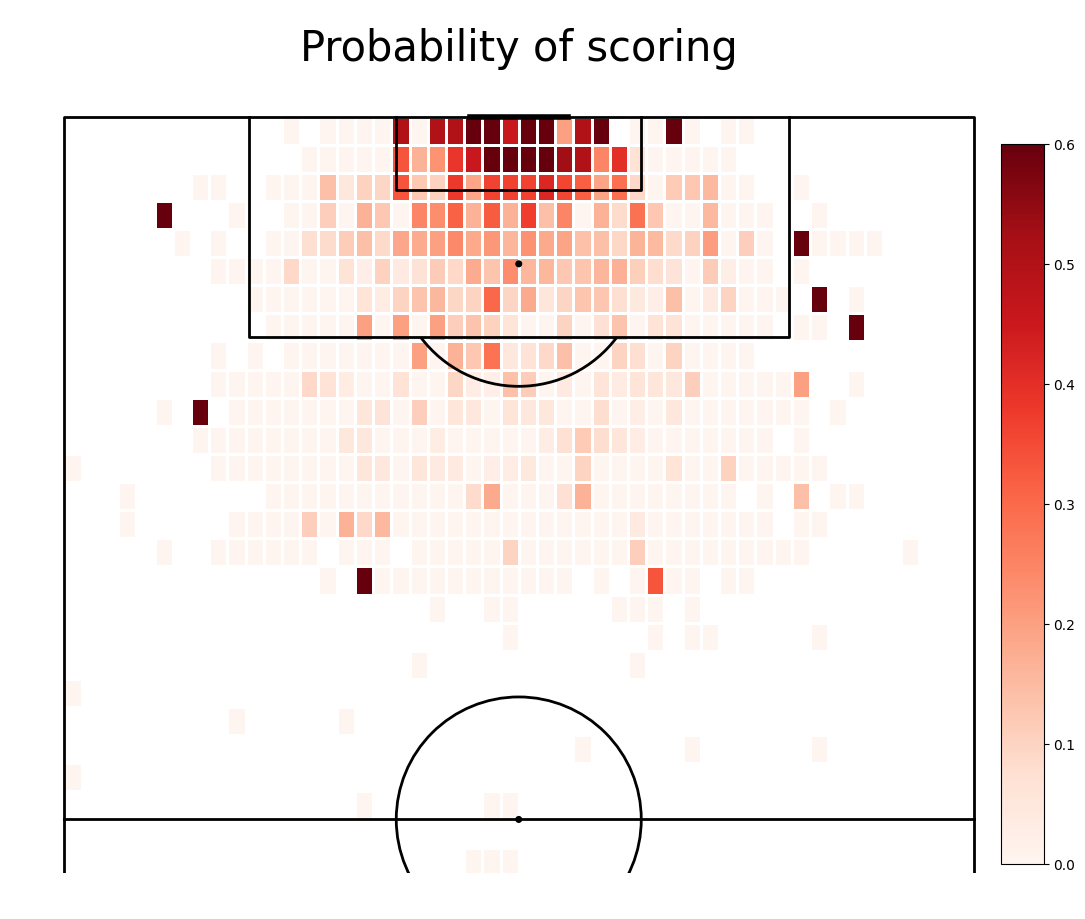

In [12]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic = pitch.bin_statistic(105 - shots.X, shots.Y, bins = 50)
#normalize number of goals by number of shots
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]
#plot heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Probability of scoring' , fontsize = 30)
plt.show()

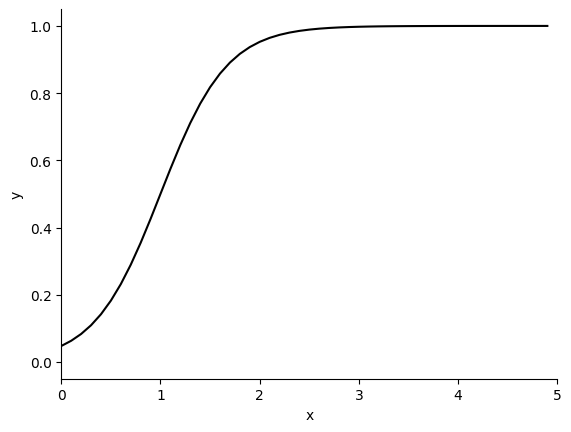

In [13]:
b = [3, -3]
x = np.arange(5, step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x))
fig,ax = plt.subplots()
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x")
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()